In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import pandas as pd
from utils import *
import torch
import random





## 1. Try some basic Visualization

In [3]:
n_sample = 3*3

xs = np.linspace(-4,4,3)
ys = np.linspace(-4,4,3)
means_x = [] 
for i in range(3):
    for j in range(3):
        means_x.append([xs[i],ys[j]])

std = np.sqrt(0.5)
u_mean = means_x

In [4]:
def plot_result(data,title,range_limit,point=True,step=1,alpha=1.0):
    bbox=[range_limit[0],range_limit[1],range_limit[0],range_limit[1]]
    df = pd.DataFrame(data)  
    fig = plt.figure(figsize=[5,5])
    # g = sns.jointplot(x=0, y=1, data=df, kind="kde", cmap='Blues', ratio=1000, n_levels=30, kernel="biw" , bw="silverman" , stat_func=None,joint_kws={'shade_lowest':False}, xlim=range_limit, ylim=range_limit )

    g = sns.JointGrid(x=0, y=1, data=df,xlim=range_limit, ylim=range_limit )
    # g = sns.jointplot(x=0, y=1, data=df, kind="kde", ratio=1000, stat_func=None,joint_kws={'shade_lowest':False}, xlim=range_limit, ylim=range_limit )
    # g = sns.jointplot(x1, x2, kind="kde", sns.kdeplot, cmap='Blues', n_levels=50, kernel="biw", bw=None, ratio=10, stat_func=None, joint_kws={'shade_lowest':True})
    
    g.plot_joint(sns.kdeplot, cmap='Blues', n_levels=50, kernel="biw", 
                 bw_method="silverman", bw_adjust=1, cut=3, thresh=0,)
    
    if point:
        g.plot_joint(plt.scatter, c="grey", s=5, linewidth=1, marker="o",alpha=alpha)
    g.set_axis_labels("", "") 
    
    plt.yticks([])
    plt.xticks([])
    plt.savefig(title+'.pdf', bbox_inches='tight')
    # g.savefig(title+'.pdf', bbox_inches='tight')
    plt.show()

In [5]:
def gmm(x):
    for i in range(n_sample):
        d=stats.multivariate_normal(u_mean[i],[[std,0.0],[0.0,std]])
        if i==0:
            ans=d.pdf(x)/n_sample
        else:
            ans+=d.pdf(x)/n_sample
    return ans

def evaluate_bivariate(range, npoints):
    side = np.linspace(range[0], range[1], npoints)
    z1, z2 = np.meshgrid(side, side)
    zv = np.hstack([z1.reshape(-1, 1), z2.reshape(-1, 1)])
    
    return z1, z2, zv

Text(0.5, 1.0, 'Target distribution')

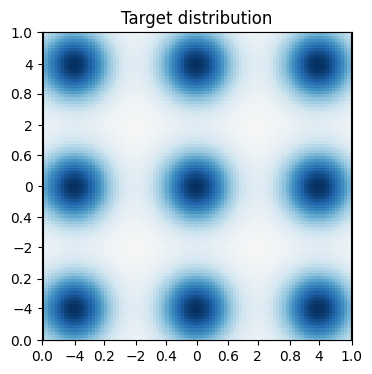

In [6]:
npoints_plot= 100
fig, _ = plt.subplots(figsize=(4, 4))
range_limit = [-5,5]

ax=plt.subplot(1,1,1, aspect='equal')
mesh_z1, mesh_z2, zv = evaluate_bivariate(range=range_limit, npoints=npoints_plot)

phat_z = gmm(zv)

phat_z=phat_z.reshape([npoints_plot,npoints_plot])
ax.pcolormesh(mesh_z1, mesh_z2, phat_z)
z_min, z_max = -np.abs(phat_z).max(), np.abs(phat_z).max()
plt.pcolor(mesh_z1, mesh_z2, phat_z, cmap='RdBu', vmin=z_min, vmax=z_max)
#plt.xlim(range_limit)
#plt.ylim(range_limit)
ax.set_title('Target distribution')
# fig.savefig('gmm_25.pdf', bbox_inches='tight')

In [7]:
phat_z_ = phat_z *1000

samples = []
for i in range(npoints_plot):
    for j in range(npoints_plot):
        nz = int(phat_z_[i,j])
        if nz > 0:
            z_ = np.tile([  mesh_z1[i,j] , mesh_z2[i,j]  ],(nz,1))
            samples.append(z_)

d:\Anaconda\envs\study\lib\site-packages\seaborn\axisgrid.py:1832: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=self.x, y=self.y, **kwargs)


<Figure size 500x500 with 0 Axes>

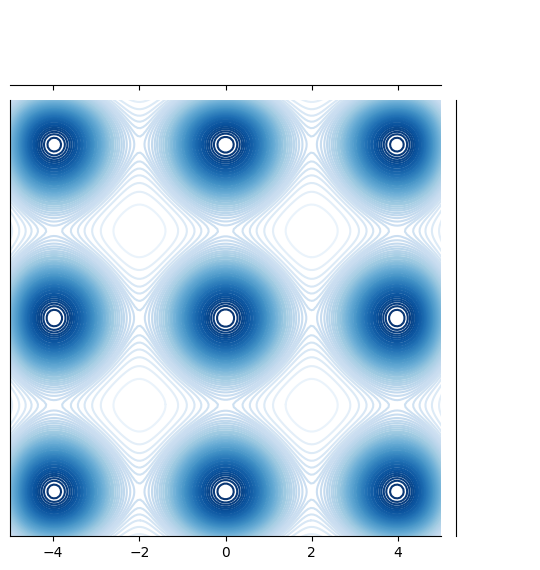

In [8]:
data = np.concatenate(samples, axis=0)
plot_result(data,'gt',range_limit,point=False)

## 2.Entropy-MCMC

In [9]:
def local_entropy(theta, eta, means, covs, weights):
    """ Compute the local entropy of a Gaussian mixture model at a given point theta """
    n = len(means)
    sum_exp = 0
    for i in range(n):
        diff = theta - means[i]
        energy = 0.5 * diff.T @ np.linalg.inv(covs[i]) @ diff
        sum_exp += weights[i] * np.exp(-energy - (1 / (2 * eta)) * diff.T @ diff)
    return np.log(sum_exp)


In [10]:

def gradient_local_entropy(theta, means, covs, weights):
    n = len(means)
    sum_exp = 0
    grad = np.zeros_like(theta)
    for i in range(n):
        diff = theta - means[i]
        invs = np.linalg.inv(covs[i])
        grad += weights[i] * np.exp(-0.5 * diff.T @ invs @ diff) * invs @ diff / (2 * np.pi * np.sqrt(np.linalg.det(covs[i])))
        #engrgy = 0.5 * diff.T @ np.linalg.inv(covs[i]) @ diff
        #grad += weights[i] * np.exp(-engrgy) * np.linalg.inv(covs[i]) @ diff
        exp = weights[i] * np.exp(-0.5 * diff.T @ invs @ diff) / (2 * np.pi * np.sqrt(np.linalg.det(covs[i])))
        sum_exp += exp

    return grad / sum_exp


In [63]:
def entropy_mcmc_sampling(start_theta, eta_schedule, means, covs, weights, n_samples=1000, step_size=0.01, sample: bool = True,cyclic=False):
    np.random.seed(123)
    samples = [start_theta]
    samples_a = [start_theta]
    theta = start_theta
    theta_a = theta
    if cyclic:
       start = 0.0; end = step_size
       M = 4
       step_size = np.zeros(n_samples)
       for rcounter in range(n_samples):
            cos_inner = pi*(rcounter%(n_samples//M))
            cos_inner /= n_samples//M
            cos_out = cos(cos_inner)+1
            step_size[rcounter] = start + (end-start)*cos_out/2
       for i in range(n_samples):
            eta = eta_schedule[i] 
            grad = gradient_local_entropy(theta, means, covs, weights)
            grad += 1/eta * (theta - theta_a)
            theta = theta - step_size[i] * grad + np.sqrt(2 * step_size[i]) * np.random.randn(*theta.shape)
            theta_a = theta_a - step_size[i] / eta * (theta_a - theta) + np.sqrt(2 * step_size[i]) * np.random.randn(*theta_a.shape)
            # print(i)
            if sample:
                if i % 200 <= 50 and i > 50:
                  samples.append(theta)
                  samples_a.append(theta_a)
            else:
                samples.append(theta)
                samples_a.append(theta_a)
    else:
        step_size = step_size
        for i in range(n_samples):
            eta = eta_schedule[i] 
            grad = gradient_local_entropy(theta, means, covs, weights)
            grad += 1/eta * (theta - theta_a)
            theta = theta - step_size * grad + np.sqrt(2 * step_size) * np.random.randn(*theta.shape)
            theta_a = theta_a - step_size / eta * (theta_a - theta) + np.sqrt(2 * step_size) * np.random.randn(*theta_a.shape)
        # print(i)
            if sample:
                if i % 200 <= 50 and i > 50:
                  samples.append(theta)
                  samples_a.append(theta_a)
            else:
                samples.append(theta)
                samples_a.append(theta_a)

    return np.array(samples), np.array(samples_a)


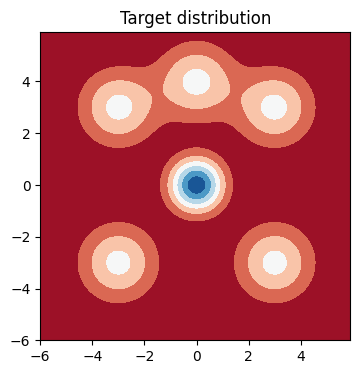

In [15]:
means = np.array([[0, 0], [3, 3], [-3, 3], [3, -3], [-3, -3], [0, 4]])
covs = [np.eye(2) *1 for _ in range(6)]
covs[0] = np.eye(2) * 0.5

weights = np.ones(6) / 6

def gaussian_mixture(x, means, covs, weights):
    n = len(means)
    result = 0
    for i in range(n):
        diff = x - means[i]
        result += weights[i] * np.exp(-0.5 * diff.T @ np.linalg.inv(covs[i]) @ diff) / (2 * np.pi * np.sqrt(np.linalg.det(covs[i])))
    return result

# Plot the target distribution
x, y = np.mgrid[-6:6:.1, -6:6:.1]
pos = np.dstack((x, y))
z = np.apply_along_axis(lambda p: gaussian_mixture(p, means, covs, weights), 2, pos)


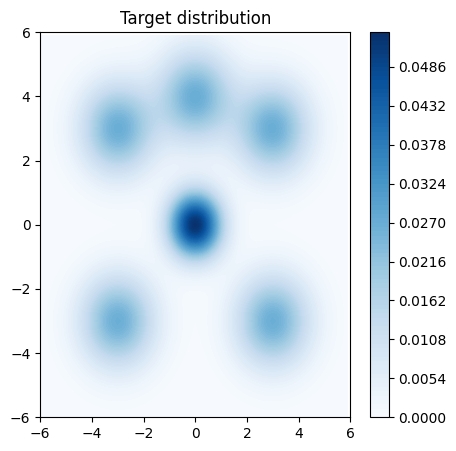

In [16]:

plt.figure(figsize=(5, 5))
plt.contourf(x, y, z, levels=100, cmap='Blues')
plt.colorbar()
plt.title('Target distribution')
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.show()

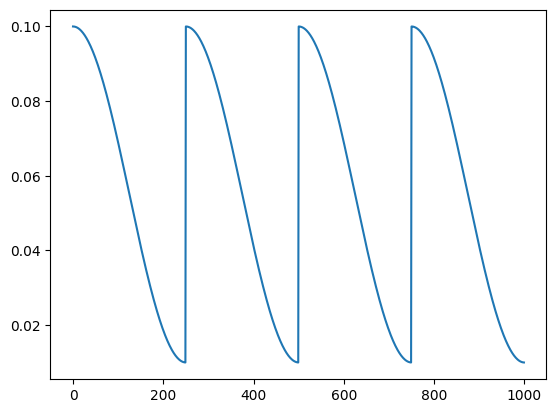

In [82]:
eta_schedule = np.ones(1000) * 0.1
start = 0.01; end = 0.1

for rcounter in range(1000):
    cos_inner = pi*(rcounter%(1000//4))
    cos_inner /= 1000//4
    cos_out = cos(cos_inner)+1
    eta_schedule[rcounter] = start + (end-start)*cos_out/2

# eta_schedule +=1e-6 
plt.plot(eta_schedule)
plt.show()

C:\Users\19613\AppData\Local\Temp\ipykernel_15388\1798402017.py:14: RuntimeWarning: invalid value encountered in divide
  return grad / sum_exp


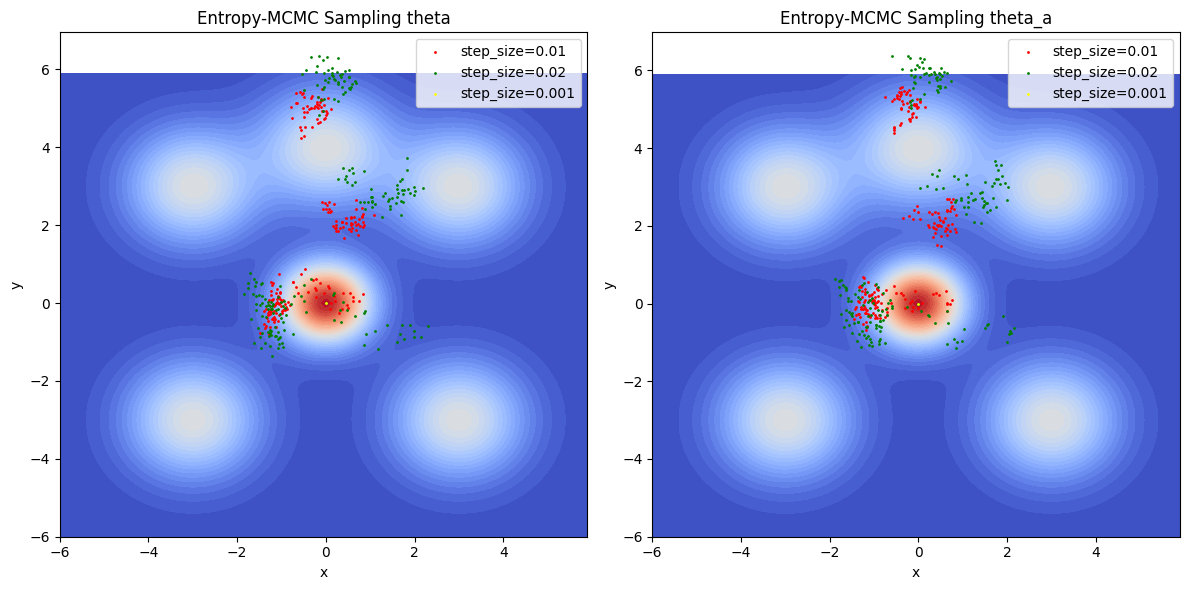

In [95]:
start_theta = np.array([0.0,0.0])
samples,samples_a = entropy_mcmc_sampling(start_theta, eta_schedule, means, covs, weights,step_size=0.01)
samples_1,samples_a_1 = entropy_mcmc_sampling(start_theta, eta_schedule, means, covs, weights,step_size=0.02)
# samples_2,samples_a_2 = entropy_mcmc_sampling(start_theta, eta_schedule, means, covs, weights,step_size=0.05)
# eta_schedule_1 = np.ones(1000) * 0.0001
samples_3,samples_a_3 = entropy_mcmc_sampling(start_theta, eta_schedule, means, covs, weights,step_size=0.001)
# Visualize the samples
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.contourf(x, y, z, levels=50, cmap='coolwarm')
#plt.plot(samples[:, 0], samples[:, 1], c='red', lw=0.5)
plt.scatter(samples[:, 0], samples[:, 1], c='red', s=1)
plt.scatter(samples_1[:, 0], samples_1[:, 1], c='green', s=1)
#plt.scatter(samples_2[:, 0], samples_2[:, 1], c='green', s=1)
plt.scatter(samples_3[:, 0], samples_3[:, 1], c='yellow', s=1)
plt.title('Entropy-MCMC Sampling theta')
plt.legend(['step_size=0.01','step_size=0.02','step_size=0.001'])
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(1, 2, 2)
plt.contourf(x, y, z, levels=50, cmap='coolwarm')
#plt.plot(samples_a[:, 0], samples_a[:, 1], c='red', lw=0.5)
plt.scatter(samples_a[:, 0], samples_a[:, 1], c='red', s=1)
plt.scatter(samples_a_1[:, 0], samples_a_1[:, 1], c='green', s=1)
#plt.scatter(samples_a_2[:, 0], samples_a_2[:, 1], c='green', s=1)
plt.scatter(samples_a_3[:, 0], samples_a_3[:, 1], c='yellow', s=1)
plt.legend(['step_size=0.01','step_size=0.02','step_size=0.001'])
plt.title('Entropy-MCMC Sampling theta_a')
plt.xlabel('x')
plt.ylabel('y')

plt.tight_layout()
plt.show()

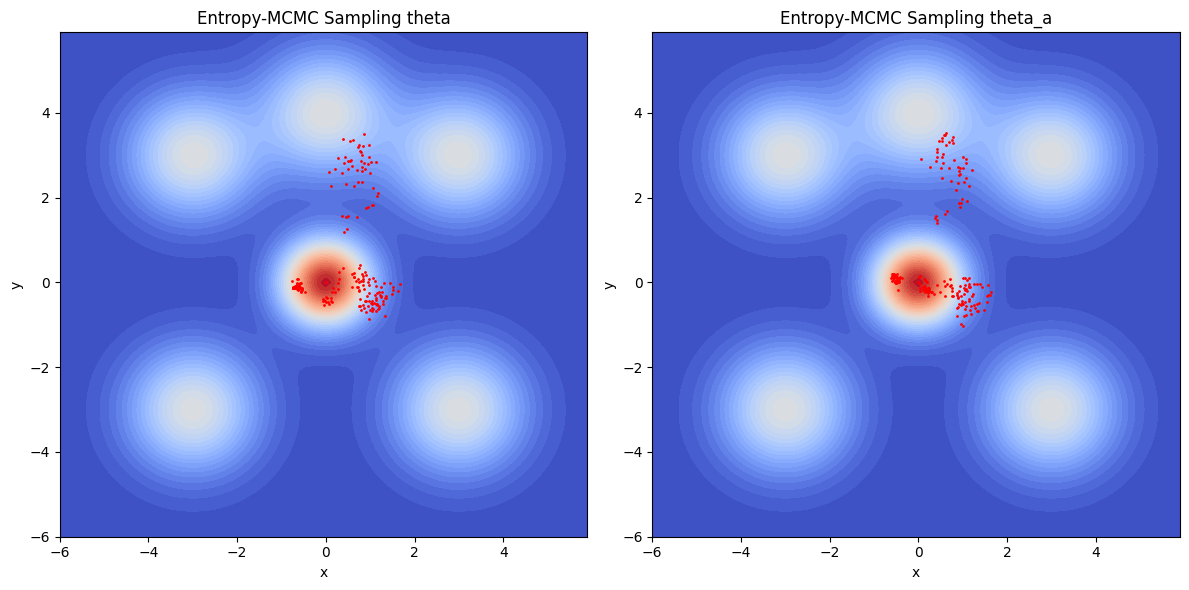

In [85]:
eta_schedule = np.ones(1000) * 0.05

start_theta = np.array([0.0,0.0])
samples,samples_a = entropy_mcmc_sampling(start_theta, eta_schedule, means, covs, weights,step_size=0.02,cyclic=True)

# Visualize the samples
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.contourf(x, y, z, levels=50, cmap='coolwarm')
#plt.plot(samples[:, 0], samples[:, 1], c='red', lw=0.5)
plt.scatter(samples[:, 0], samples[:, 1], c='red', s=1)
plt.title('Entropy-MCMC Sampling theta')
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(1, 2, 2)
plt.contourf(x, y, z, levels=50, cmap='coolwarm')
#plt.plot(samples_a[:, 0], samples_a[:, 1], c='red', lw=0.5)
plt.scatter(samples_a[:, 0], samples_a[:, 1], c='red', s=1)
plt.title('Entropy-MCMC Sampling theta_a')
plt.xlabel('x')
plt.ylabel('y')

plt.tight_layout()
plt.show()